<h1><b>Sentiment Analysis  </b></h1>
<li><b>Name:</b> Shankalpa Pokharel</li>



<h1>Importing the Necessary Libraries</h1>
To create our analysis model, we need to import several libraries. We'll use pandas to handle data, numpy for math, nltk for natural language processing, and 'punkt' tokenizer from NLTK library to break up text into smaller pieces. We'll also use porter stemmer to simplify words, model_selection to split data for training and testing, metrics to evaluate our model, models to build layers for our deep neural network, keras to construct the network, tqdm to track our progress, and os to access system-dependent features.

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import plot_model
import keras
from tqdm import tqdm
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<h1>Mount Google Drive</h1>
<p>We'll be using Colab for all of our basic operations, and we'll also be using Google Drive in conjunction with it.</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1>Specify Path</h1>
<p>To make it easier for us to access, we'll specify the path for the various datasets we'll be using for training and loading our model. This way, we can use the same path for all our training operations.</p>

In [ ]:
# Set paths for review data, model checkpoints, and model saves
REVIEW_PATH = '/content/drive/MyDrive/NLP AMAZON DATA/Review Data'
CHECKPOINT_PATH = '/content/drive/MyDrive/NLP AMAZON DATA/Model Check Reg/'
CHECKPOINT_PATH_ATT = '/content/drive/MyDrive/NLP AMAZON DATA/Model Check Att/'
SAVE_PATH = '/content/drive/MyDrive/NLP AMAZON DATA/Model Save Reg/'
SAVE_PATH_ATT = '/content/drive/MyDrive/NLP AMAZON DATA/Model Save Att/'

# Load review data from a CSV file
# REVIEW_PATH + '/kindle_review.csv' is the path to the file
data = pd.read_csv(REVIEW_PATH + '/kindle_review.csv')


In [ ]:
data.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


<h1>Preprocess Text</h1>
<p>In this section, we'll preprocess the text from reviewText so we can use it for training.</p>
<p> Here are the steps we'll follow:</p>
<li>Remove HTML tags from the review text</li>
<li>Remove punctuation from the review text</li>
<li>Remove digits from the review text</li>
<li>Convert the resulting text to lowercase</li>
<li>Remove stop words like 'a', 'an', 'the' etc.</li>
<li>Lemmatize the filtered text and return it using the clean_text(text) function</li>

In [ ]:
# Tokenize the text
def tokenize_text(text):
    return nltk.word_tokenize(text)

In [ ]:
def remove_stop_words(text):
    # Return a list of words that are not in the stop words set
    return [word for word in text if word not in stop_words]


In [ ]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub('<[^>]*>', '', text)

    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stop words
    text_tokens = tokenize_text(text)
    tokens_without_stopwords = remove_stop_words(text_tokens)
    filtered_text = ' '.join(tokens_without_stopwords)

    # Lemmatize Text
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in filtered_text.split()])

    return lemmatized_text

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords

# We apply the cleaning onto our reviewText
stop_words = set(stopwords.words('english'))
data['reviewText'] = data['reviewText'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data.head() # Here we can visualize the cleaned text in the reviewText Column as compared to before

,Unnamed: 0,rating,reviewText,summary
0,0,5,book first bookmobile book bought school book ...,50 + years ago...
1,1,1,read description book couldnt wait read downlo...,Boring! Boring! Boring!
2,2,5,edit review book believe got right updated rew...,Wiggleliscious/new toy ready/!!
3,3,5,dont normally buy mystery novel dont like howe...,Very good read.
4,4,5,isnt kind book normally read although try limi...,Great Story!


<h1>Creating a Corpus</h1>
<p>In this step, we'll create a corpus, which is the entire vocabulary of the given dataset generated from the preprocessed review text in the previous section. We'll append the preprocessed reviewText to the corpus list.</p>

In [ ]:
corpus = []

# Extract review text from data and add to corpus list
for i in tqdm(range(len(data))):
    corpus.append(data['reviewText'][i])


100%|██████████| 12000/12000 [01:24<00:00, 141.66it/s]


In [ ]:
import pickle

# Let's save the corpus
with open(SAVE_PATH + '/corpus.pkl', 'wb') as f:
    pickle.dump(corpus, f)

In [ ]:
# Let's load the corpus again
import pickle
corpus = []

with open(SAVE_PATH + '/corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)

print(len(corpus))

12000


<h1>Define Input and Output</h1>
<p>In this phase, we'll first use a tokenizer to break down our corpus into individual words. This generates tokens for each word in the corpus. Next, we'll calculate the maximum length of the preprocessed review text. Finally, we'll define the input 'X' as the padded sequences of tokens generated from the corpus, and 'y' as the variable to be predicted. We'll also convert the rating so that we can use binary classification, meaning either a negative or positive review.</p>

In [ ]:
# Import necessary libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert text to sequences of word embeddings
tokenizer = Tokenizer()  # Create a tokenizer object
tokenizer.fit_on_texts(corpus)  # Fit the tokenizer on the text corpus
sequences = tokenizer.texts_to_sequences(corpus)  # Convert the text to sequences of integer indices
word_index = tokenizer.word_index  # Create a word-to-index dictionary from the tokenizer
max_len = max([len(x) for x in sequences])  # Determine the maximum sequence length
X = pad_sequences(sequences, maxlen=max_len)  # Pad the sequences to a fixed length
y = data['rating'].apply(lambda x: 1 if x > 3 else 0).values  # Convert ratings to binary labels


In [ ]:
X

array([[    0,     0,     0, ...,   250,  8507,  1002],
       [    0,     0,     0, ...,    16,     9,    71],
       [    0,     0,     0, ...,    99,    94,  1814],
       ...,
       [    0,     0,     0, ...,   492,   756, 33515],
       [    0,     0,     0, ...,    21,   149,     3],
       [    0,     0,     0, ...,  1400,   551,  4279]], dtype=int32)

In [ ]:
y

array([1, 0, 1, ..., 1, 1, 1])

<h1>Train Test Splitting</h1>
<p>We utilize the standard train test split of 80:20 such that 80% data is utilized for training and 20% data is utilized for testing.

In [ ]:
# Train Test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

<h1>Defining a Regular Model</h1>
<p>First, we'll use a simple model to train our sentiment analysis architecture. This model has 5 layers, each serving a specific purpose:</p>
<li>The first layer (Embedding Layer) converts the vocabulary size to a matrix that the second layer can process.</li>
<li>The second layer (LSTM) analyzes the embedding layer and identifies long-term dependencies in the sequence to understand the sentiment in the context of the text.</li>
<li>The following 2 layers (Dense Layers) help the model understand higher-level abstract features.</li>
<li>The final dense layer acts as an interface between the output of the previous two dense layers and the final output of the model, which is either a positive or negative review.</li>

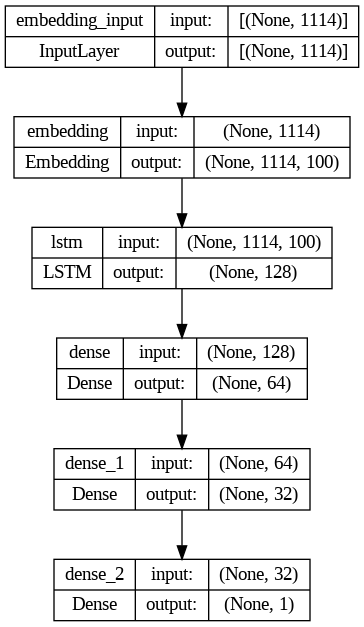

In [ ]:
# Define the LSTM model architecture
embedding_dim = 100  # Dimensionality of the embedding space
vocab_size = len(word_index) + 1  # Size of the vocabulary

model = Sequential()  # Create a sequential model
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))  # Add an embedding layer
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # Add an LSTM layer with dropout
model.add(Dense(64, activation='relu'))  # Add a fully connected layer with ReLU activation
model.add(Dense(32, activation='relu'))  # Add another fully connected layer with ReLU activation
model.add(Dense(1, activation='sigmoid'))  # Add a final fully connected layer with sigmoid activation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Compile the model with binary cross-entropy loss and Adam optimizer

# Visualize the model architecture
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)


<h1>Defining Attention Model</h1>
<p>Attention model is a powerful algorithm that helps identify the intricacies of dependencies in a sequence problem. In the case of sentiment analysis the attention model is utilized such that the model can learn the textual bits and pieces that mostly contribute to the decision of the model. In this case only binary, i.e. either a positive review or negative review. (Just converting the output layer=5 with a softmax activation could be used in this context to predict 5 review classes. However, binary is enough to classify the gist of the textual information). This model also defines 5 input layers. Furthermore, to implement attention, the layer after LSTM is used as attention layer which captures the hidden states of LSTM timestep output, computes the score vector for each timestep - which are then normalized - the context vector which is the vector information representation of language attention data is then concatenated with the final attention hidden state is passed through a dense layer with no hidden and with tanh as activation function to normalize the output from this layer. The five layers in this model represent:
<li>First layer (Embedding Layer just like with the regular model) embeds the input vector for the LSTM to be able to process</li>
<li>Second layer (LSTM) takes the embedding layer and identifies the long term dependency of textual data in each time step</li>
<li>Third layer (Attention) takes the output from LSTM in each time step, extracts the hidden layer information to provide a score for each time-step and finally merges the score as a dot product, this is then fed to a context vector (which has the information about the context of textual information in that specific time step)</li>
<li>The following two dense layers helps recognize high level features from the input texts.</h1>
<li>Finally, the final output layer acts as interface between dense layer and output layer</li>


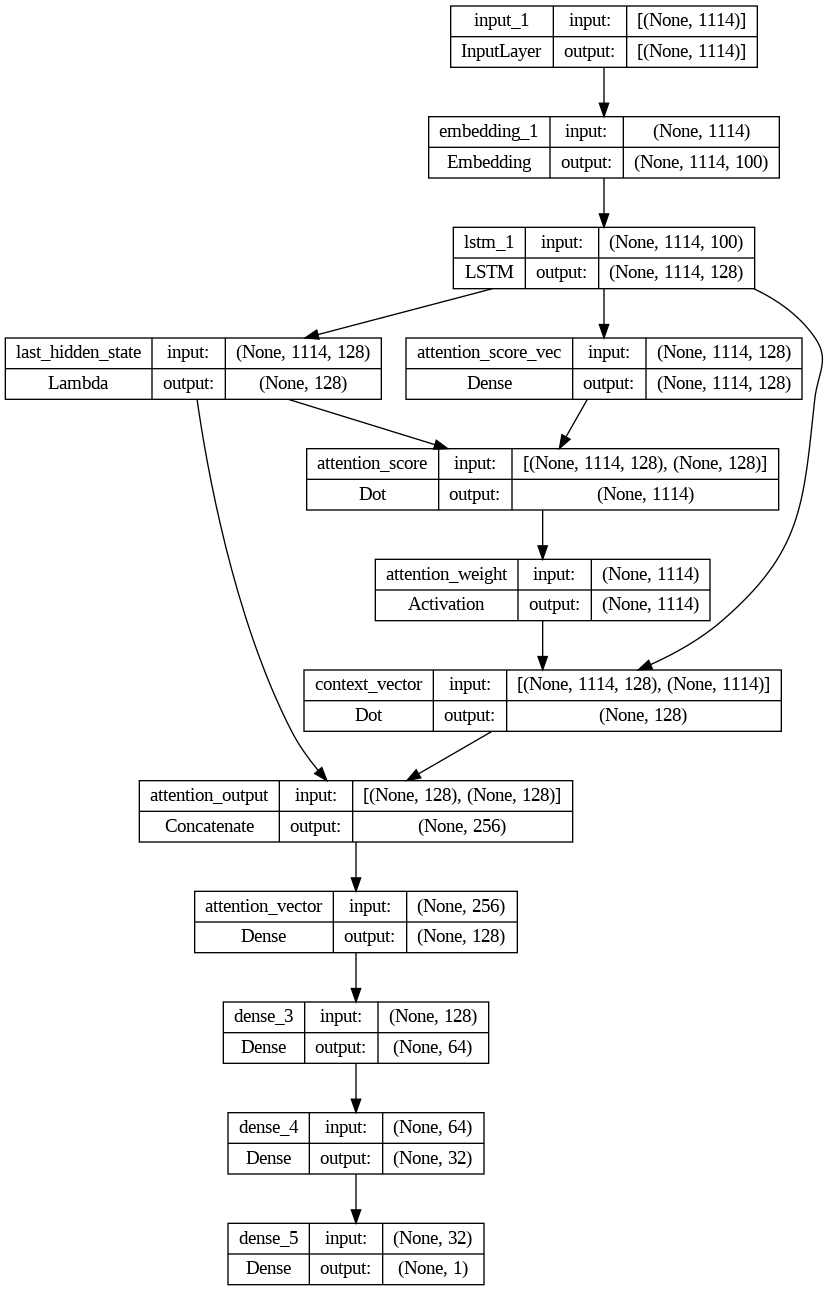

In [ ]:
from keras.layers import *
from keras import backend as K
from keras.models import Model

# Define the attention mechanism function
def attention_fn(inputs):
    hidden_states = inputs # Inputs to attention mechanism
    hidden_size = int(hidden_states.shape[2]) # Number of hidden units in the LSTM layer
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states) # Dense layer with no bias to compute scores for each hidden state vector
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states) # Extract the last hidden state output of the LSTM layer
    score = dot([score_first_part, h_t], [2, 1], name='attention_score') # Compute scores by taking the dot product between score_first_part and the last hidden state
    attention_weights = Activation('softmax', name='attention_weight')(score) # Apply softmax to obtain the attention weights
    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector') # Compute the context vector by taking the weighted sum of hidden states
    pre_activation = concatenate([context_vector, h_t], name='attention_output') # Concatenate the context vector and the last hidden state
    attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation) # Pass the concatenated vector through a dense layer to obtain the final attention vector
    return attention_vector

# Define the LSTM model with attention mechanism
embedding_dim = 100
vocab_size = len(word_index) + 1
inputs = Input(shape=(max_len,))
x = Embedding(vocab_size, embedding_dim, input_length=max_len)(inputs) # Embedding layer to convert text input to word vectors
x = LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(x) # LSTM layer with dropout and recurrent dropout to prevent overfitting, and return_sequences set to True to return the full sequence of outputs
x = attention_fn(x) # Apply attention mechanism to the output of the LSTM layer
x = Dense(64, activation='relu')(x) # Dense layer with 64 units and ReLU activation
x = Dense(32, activation='relu')(x) # Dense layer with 32 units and ReLU activation
outputs = Dense(1, activation='sigmoid')(x) # Output layer with sigmoid activation for binary classification
model_Att = Model(inputs=inputs, outputs=outputs) # Instantiate the model

# Compile the model with binary crossentropy loss and Adam optimizer
model_Att.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Plot the model architecture
plot_model(model_Att, to_file='lstm_attention_model.png', show_shapes=True, show_layer_names=True)


<h1>Regular Model Checkpointing and Training</h1>
<p>In this section, we'll create a checkpoint callback for our regular model that will be used when fitting the model. This will save only the best weights for the model. Additionally, multiple models will be saved during the training process so that we can access them for visualization later on. We'll also save the evaluation metrics as pickle files, so we can access them for visualizing the model's performance in the future.</p>

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

checkpoint_freq = "epoch"

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(CHECKPOINT_PATH, save_freq=checkpoint_freq)

In [ ]:
if os.path.isfile(CHECKPOINT_PATH):
    print("Loading model weights from checkpoint...")
    model.load_weights(CHECKPOINT_PATH)

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []
epochs = 10
batch_size = 32

for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch+1, epochs))
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

    # Save training and validation accuracy and loss
    train_loss.append(history.history['loss'][0])
    train_acc.append(history.history['accuracy'][0])
    val_loss.append(history.history['val_loss'][0])
    val_acc.append(history.history['val_accuracy'][0])

    # Save training and validation accuracy and loss history to a file
    with open(SAVE_PATH + 'train_history' + str(epoch) + '.pkl', 'wb') as f:
        pickle.dump({'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc}, f)

    # Save final model
    model.save(SAVE_PATH + 'model_main_V' + str(epoch) + '.h5')

Epoch 1/10
240/240 [==============================] - 611s 3s/step - loss: 0.5531 - accuracy: 0.7270 - val_loss: 0.4436 - val_accuracy: 0.7922
Epoch 2/10
240/240 [==============================] - 575s 2s/step - loss: 0.3157 - accuracy: 0.8723 - val_loss: 0.4806 - val_accuracy: 0.7984
Epoch 3/10
240/240 [==============================] - 568s 2s/step - loss: 0.1995 - accuracy: 0.9243 - val_loss: 0.6111 - val_accuracy: 0.7865
Epoch 4/10
240/240 [==============================] - 562s 2s/step - loss: 0.1387 - accuracy: 0.9486 - val_loss: 0.6696 - val_accuracy: 0.7776
Epoch 5/10
240/240 [==============================] - 564s 2s/step - loss: 0.0802 - accuracy: 0.9706 - val_loss: 1.0463 - val_accuracy: 0.7563
Epoch 6/10
240/240 [==============================] - 552s 2s/step - loss: 0.0701 - accuracy: 0.9755 - val_loss: 1.2093 - val_accuracy: 0.7469
Epoch 7/10
240/240 [==============================] - 554s 2s/step - loss: 0.0565 - accuracy: 0.9798 - val_loss: 1.1478 - val_accuracy: 0.7563


<h1>Attention Model Checkpointing and Training</h1>
<p>In this section, we'll create a checkpoint callback for our attention model that will be used when fitting the model. This will save only the best weights for the model. Additionally, multiple models will be saved during the training process so that we can access them for visualization later on. We'll also save the evaluation metrics as pickle files, so we can access them for visualizing the model's performance in the future.</p>

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

checkpoint_freq = "epoch"

# Define the checkpoint callback
checkpoint_callback_Att = ModelCheckpoint(CHECKPOINT_PATH_ATT, save_freq=checkpoint_freq)

In [ ]:
if os.path.isfile(CHECKPOINT_PATH_ATT):
    print("Loading model weights from checkpoint...")
    model.load_weights(CHECKPOINT_PATH_ATT)

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch+1, epochs))
    history = model_Att.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data=(X_val, y_val), callbacks=[checkpoint_callback_Att])

    # Save training and validation accuracy and loss
    train_loss.append(history.history['loss'][0])
    train_acc.append(history.history['accuracy'][0])
    val_loss.append(history.history['val_loss'][0])
    val_acc.append(history.history['val_accuracy'][0])

    # Save training and validation accuracy and loss history to a file
    with open(SAVE_PATH + 'train_history_attention' + str(epoch) + '.pkl', 'wb') as f:
        pickle.dump({'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc}, f)

    # Save final model
    model_Att.save(SAVE_PATH + 'model_main_Att_V' + str(epoch) + '.h5')

Epoch 1/10
240/240 [==============================] - 582s 2s/step - loss: 0.5097 - accuracy: 0.7518 - val_loss: 0.4325 - val_accuracy: 0.8026
Epoch 2/10
240/240 [==============================] - 560s 2s/step - loss: 0.3061 - accuracy: 0.8798 - val_loss: 0.4667 - val_accuracy: 0.7979
Epoch 3/10
240/240 [==============================] - 553s 2s/step - loss: 0.1998 - accuracy: 0.9257 - val_loss: 0.5820 - val_accuracy: 0.7932
Epoch 4/10
240/240 [==============================] - 551s 2s/step - loss: 0.1068 - accuracy: 0.9620 - val_loss: 0.7282 - val_accuracy: 0.7656
Epoch 5/10
240/240 [==============================] - 548s 2s/step - loss: 0.0769 - accuracy: 0.9740 - val_loss: 0.7990 - val_accuracy: 0.7760
Epoch 6/10
240/240 [==============================] - 546s 2s/step - loss: 0.0497 - accuracy: 0.9852 - val_loss: 0.9965 - val_accuracy: 0.7703
Epoch 7/10
240/240 [==============================] - 550s 2s/step - loss: 0.0470 - accuracy: 0.9841 - val_loss: 1.1932 - val_accuracy: 0.7703

<h1>Testing Regular Model</h1>
<p>First we load the best model in terms of accuracy (validation accuracy for our regular model) and identify their evaluation metrics such as Accuracy, Precision, Recall and F1 Score).

In [ ]:
# Evaluate the model on the test set
import keras

model = keras.models.load_model(SAVE_PATH + 'model_main_V0.h5')

y_pred = model.predict(X_test)
y_pred = [1 if y >= 0.5 else 0 for y in y_pred]
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision: {:.2f}%".format(precision_score(y_test, y_pred)*100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_pred)*100))
print("F1 Score: {:.2f}%".format(f1_score(y_test, y_pred)*100))

75/75 [==============================] - 23s 308ms/step
Accuracy: 79.71%
Precision: 77.90%
Recall: 82.42%
F1 Score: 80.10%


<h1>Testing Attention Model</h1>
<p>Secondly we load the best model in terms of accuracy (validation accuracy for our attention model) and identify their evaluation metrics such as Accuracy, Precision, Recall and F1 Score).

In [ ]:
# Evaluate the model on the test set
import keras

model_Att = keras.models.load_model(SAVE_PATH + 'model_main_Att_V0.h5')

y_predAtt = model_Att.predict(X_test)
y_predAtt = [1 if y >= 0.5 else 0 for y in y_predAtt]
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_predAtt)*100))
print("Precision: {:.2f}%".format(precision_score(y_test, y_predAtt)*100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_predAtt)*100))
print("F1 Score: {:.2f}%".format(f1_score(y_test, y_predAtt)*100))

75/75 [==============================] - 24s 320ms/step
Accuracy: 80.17%
Precision: 78.00%
Recall: 83.52%
F1 Score: 80.67%


<h1>Validation Metrics Load</h1>
<p>Validation metrics are opened from saved pickles in the drive, finally they are all loaded in their respective lists and plotted in the later section of this code.</p>

In [ ]:
import pickle
import matplotlib.pyplot as plt
import itertools

import os

# List for validation metrics of regular model
train_histreg_val_acc = []
train_histreg_val_loss = []
train_histreg_train_acc = []
train_histreg_train_loss = []

# List for validation metrics of attention model
train_histatt_val_acc = []
train_histatt_val_loss = []
train_histatt_train_acc = []
train_histatt_train_loss = []

# Iterate over the pickles and append respective values in appropriate lists for regular model
for i in range(10):
    filename = os.path.join(SAVE_PATH, f'train_history{i}.pkl')
    with open(filename, 'rb') as file:
        history = pickle.load(file)
    train_histreg_val_acc.append(history['val_acc'])
    train_histreg_val_loss.append(history['val_loss'])
    train_histreg_train_acc.append(history['train_acc'])
    train_histreg_train_loss.append(history['train_loss'])
    history = {}

# Iterate over the pickles and append respective values in appropriate lists for attention model
for i in range(10):
    filename = os.path.join(SAVE_PATH, f'train_history_attention{i}.pkl')
    with open(filename, 'rb') as file:
        historyAtt = pickle.load(file)
    train_histatt_val_acc.append(historyAtt['val_acc'])
    train_histatt_val_loss.append(historyAtt['val_loss'])
    train_histatt_train_acc.append(historyAtt['train_acc'])
    train_histatt_train_loss.append(historyAtt['train_loss'])
    historyAtt = {}

<h1>Visualizing Validation Metrics (Regular Model)</h1>
<p>Validation metrics are visualized in this section for regular model</p>

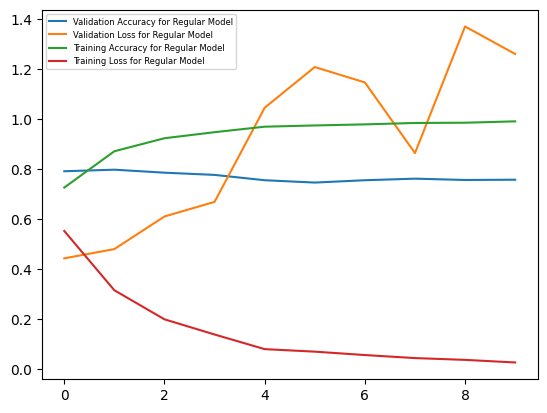

In [ ]:
plt.plot(train_histreg_val_acc[9], label='Validation Accuracy for Regular Model')
plt.plot(train_histreg_val_loss[9], label='Validation Loss for Regular Model')
plt.plot(train_histreg_train_acc[9], label='Training Accuracy for Regular Model')
plt.plot(train_histreg_train_loss[9], label='Training Loss for Regular Model')
plt.legend(fontsize=6)
plt.show()

<h1>Visualizing Validation Metrics (Attention)</h1>
<p>Validation metrics are visualized in this section for attention model</p>

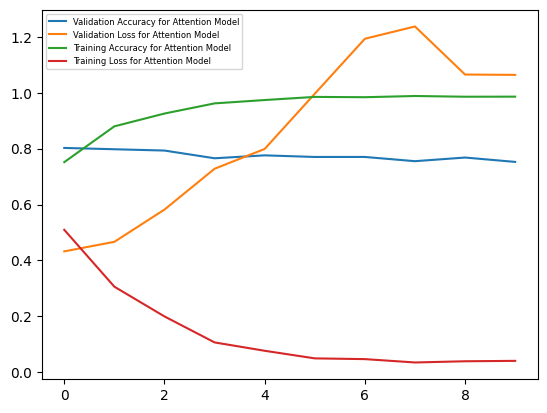

In [ ]:
plt.plot(train_histatt_val_acc[9], label='Validation Accuracy for Attention Model')
plt.plot(train_histatt_val_loss[9], label='Validation Loss for Attention Model')
plt.plot(train_histatt_train_acc[9], label='Training Accuracy for Attention Model')
plt.plot(train_histatt_train_loss[9], label='Training Loss for Attention Model')
plt.legend(fontsize=6)
plt.show()

<h1>AUC ROC for Regular Model</h1>
<p>In this section, we evaluate the performance of the regular model using the AUC ROC evaluation metric, which is commonly used for binary classification tasks like this sentiment analysis system. AUC ROC plots the true positive rate against the false positive rate and provides a measure of the accuracy of the classification system.

The regular model was evaluated and it was found that the AUC ROC curve shows a positive deviation, which means that the model performs well overall and is not stagnating towards the baseline. This suggests that the regular model is able to effectively classify positive and negative reviews in the dataset.</p>

75/75 [==============================] - 24s 318ms/step


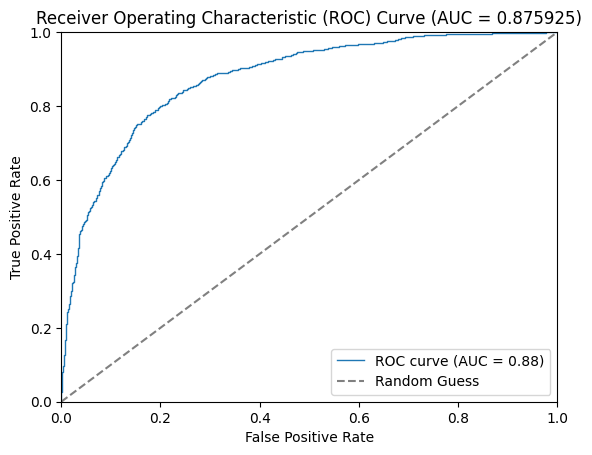

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (AUC = %0.6f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

<h1>AUC ROC for Attention Model</h1>
<p>AUC ROC for attention model. </p>

75/75 [==============================] - 26s 343ms/step


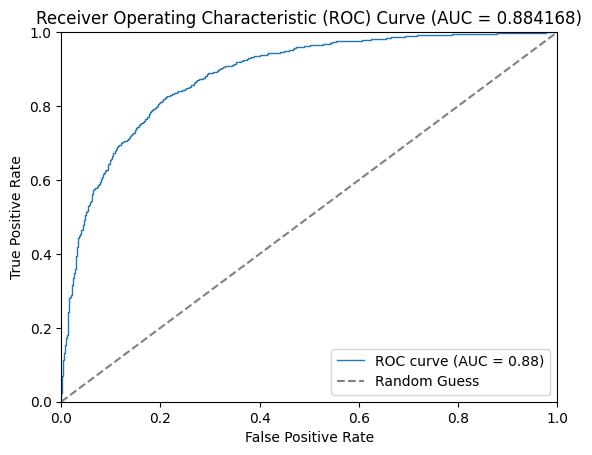

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_predAtt = model_Att.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_predAtt)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (AUC = %0.6f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

<h1>Conclusion</h1>
<p>The goal of this project was to develop models for sentiment analysis on a dataset of Amazon Kindle reviews. Two types of models were used: a regular model and an attention model. The models were trained to predict the sentiment expressed in review texts with high accuracy. The models were evaluated using various metrics, including accuracy, precision, recall, F1 score, and AUC-ROC. Both models achieved high accuracies of 79% and 80% respectively, and AUC-ROC analysis showed that both models were more accurate than inaccurate. In conclusion, the models developed in this project show promising results for sentiment analysis on Amazon Kindle reviews.</p>